In [90]:
from __future__ import annotations
import itertools as it

import pandas as pd
from pandas.api.types import is_numeric_dtype
import xlsxwriter

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

## 0 - Preparation
### 0.0 - Data import

In [91]:
DATA_FILE = "data/cleaned data.xlsx"
DESCR_FILE = "data/table_fields.xlsx"

In [92]:
df_raw = pd.read_excel(DATA_FILE, sheet_name=1)
df_raw.head()

,name,essround,edition,proddate,idno,cntry,nwspol,netusoft,netustm,ppltrst,...,uempla,uempli,dsbld,rtrd,cmsrv,hswrk,dweight,pspwght,pweight,anweight
0,ESS9e03_1,9,3.1,17.02.2021,3,IT,60,4,120,2,...,0,1,0,0,0,0,1.019588,0.924885,1.909064,1.765664
1,ESS9e03_1,9,3.1,17.02.2021,13,IT,8888,5,240,5,...,0,1,0,0,0,0,1.038898,0.954811,1.909064,1.822796
2,ESS9e03_1,9,3.1,17.02.2021,31,IT,30,5,180,4,...,0,0,0,0,0,0,1.050053,0.816516,1.909064,1.558781
3,ESS9e03_1,9,3.1,17.02.2021,58,IT,900,5,180,6,...,0,0,0,0,0,0,0.872215,0.986662,1.909064,1.883601
4,ESS9e03_1,9,3.1,17.02.2021,122,IT,60,5,15,2,...,0,0,0,0,0,0,1.019588,1.436108,1.909064,2.741621


In [93]:
# Create a copy of original data to be modified
df = df_raw.copy()

In [94]:
df_descr = pd.read_excel(DESCR_FILE)
df_descr.set_index("Name", drop=True, append=False, inplace=True)
df_descr.head()

,Label,Type,Format,Valid,Invalid,Question
Name,,,,,,
cntry,Country,discrete,character-2,49519.0,0.0,5 Country
dweight,Design weight,continuous,numeric-4.2,49519.0,0.0,R17 Design weight
pspwght,Post-stratification weight including design we...,continuous,numeric-4.2,49519.0,0.0,R18 Post-stratification weight including desig...
pweight,Population size weight (must be combined with ...,continuous,numeric-8.2,49519.0,0.0,R19 Population size weight (must be combined w...
anweight,Analysis weight,continuous,numeric-4.2,49519.0,0.0,Analysis weight


### 0.1 Create helper function to get summary of columns

In [95]:
def get_summary_table(df: pd.DataFrame,
                      target_col: str,
                      corr_method: str="pearson",
                      descr_df: pd.DataFrame=None,
                      descr_cols: list[str]=["Label", "Type"]) -> pd.DataFrame:
    """Return a pandas dataframe where each row corresponds to a column of df
    and each column contans some properties of that column from df.

    Parameters
    ----------
    df : pd.DataFrame
        The pandas dataframe of shape (N, K) containing the data.
    target_col : str
        The label of the column that contains the variable of interest which
        will be studied as the dependent variable. 
    corr_method : {‘pearson’, ‘kendall’, ‘spearman’} or callable
        Method to be used to compute the correlation with target col. By default
        is 'pearson'.
    descr_df : pd.DataFrame, optional
        If dataframe is passed, it will be merged on summary table. The passed
        dataframe should have the variables codes as index. If None, nothing
        happens. By default is None.
    descr_cols : list[str], optional
        List of columns labels to be imported from descr_df. By default is
        'Label' and 'Type'.

    Returns
    -------
    pd.DataFrame
        Dataframe of shape (K, 9).
    """
    df_summary = pd.DataFrame({
    "IS_NUMERIC": df.apply(lambda x: int(is_numeric_dtype(x))),
    "N_UNIQUE" : df.apply(lambda x: x.nunique()),
    "NA_ABS" : df.apply(lambda x: x.isna().sum()),
    "NA_REL": df.apply(lambda x: x.isna().mean()),
    "MIN": df.apply(lambda x: x.min() if is_numeric_dtype(x) else np.nan),
    "MAX": df.apply(lambda x: x.max() if is_numeric_dtype(x) else np.nan),
    "MEAN": df.apply(lambda x: x.mean() if is_numeric_dtype(x) else np.nan),
    "MEDIAN": df.apply(lambda x: x.median() if is_numeric_dtype(x) else np.nan),
    "CORR_TARGET": df.apply(lambda x: x.corr(df[target_col], method=corr_method) if is_numeric_dtype(x) else np.nan),
    "SHARE_MOST_FREQ": df.apply(lambda x: x.value_counts(normalize=True).max()),
    }).round(2)
    df_summary.sort_index(inplace=True)
    
    if descr_df is None:
        return df_summary
    
    df_summary = pd.merge(
        df_summary,
        df_descr[descr_cols],
        how="left",
        left_index=True,
        right_index=True
    )
    df_summary.columns = df_summary.columns.str.upper()
    return df_summary

In [96]:
df_summary = get_summary_table(df, target_col="happy")
df_summary

,IS_NUMERIC,N_UNIQUE,NA_ABS,NA_REL,MIN,MAX,MEAN,MEDIAN,CORR_TARGET,SHARE_MOST_FREQ
acldnmr,1,7,0,0.0,1.0,8.0,3.48,4.0,0.13,0.43
actrolga,1,7,0,0.0,1.0,8.0,2.06,2.0,0.06,0.38
admdw,1,3,0,0.0,1.0,3.0,1.99,2.0,0.01,0.34
admge,1,2,0,0.0,1.0,2.0,1.49,1.0,0.02,0.51
advcyc,1,7,0,0.0,1.0,8.0,3.07,3.0,0.10,0.41
...,...,...,...,...,...,...,...,...,...,...
yrbrn4,1,65,0,0.0,1929.0,8888.0,5458.05,6666.0,-0.00,0.73
yrbrn5,1,46,0,0.0,1940.0,8888.0,6358.60,6666.0,0.02,0.93
yrbrn6,1,29,0,0.0,1935.0,6666.0,6581.03,6666.0,0.00,0.98
yrbrn7,1,11,0,0.0,1942.0,6666.0,6645.60,6666.0,-0.01,1.00


## 1 - Variables selection


### 1.1 - Drop variables with a single value
We first drop the columns attaining a single value, as they provide no information at all.

In [97]:
unique_val_cols = df_summary[df_summary["N_UNIQUE"] == 1].index
unique_val_cols

Index(['cmsrv', 'cntry', 'dscrna', 'edition', 'essround', 'name', 'proddate',
       'pweight'],
      dtype='object')

In [98]:
df.drop(columns=unique_val_cols, inplace=True)

We can update the summary df, we see that we have now 176 variables.

In [99]:
df_summary = get_summary_table(df, target_col="happy")
df_summary

,IS_NUMERIC,N_UNIQUE,NA_ABS,NA_REL,MIN,MAX,MEAN,MEDIAN,CORR_TARGET,SHARE_MOST_FREQ
acldnmr,1,7,0,0.0,1.0,8.0,3.48,4.0,0.13,0.43
actrolga,1,7,0,0.0,1.0,8.0,2.06,2.0,0.06,0.38
admdw,1,3,0,0.0,1.0,3.0,1.99,2.0,0.01,0.34
admge,1,2,0,0.0,1.0,2.0,1.49,1.0,0.02,0.51
advcyc,1,7,0,0.0,1.0,8.0,3.07,3.0,0.10,0.41
...,...,...,...,...,...,...,...,...,...,...
yrbrn4,1,65,0,0.0,1929.0,8888.0,5458.05,6666.0,-0.00,0.73
yrbrn5,1,46,0,0.0,1940.0,8888.0,6358.60,6666.0,0.02,0.93
yrbrn6,1,29,0,0.0,1935.0,6666.0,6581.03,6666.0,0.00,0.98
yrbrn7,1,11,0,0.0,1942.0,6666.0,6645.60,6666.0,-0.01,1.00


### 1.2 - Drop variables concerning the conduction of the study
There are a few columns merely related to the conduction of the study, we can drop them.

In [100]:
df.drop(columns=["idno", "dweight", "pspwght", "anweight"], inplace=True)

There are now 172 variables in the dataset.

In [101]:
df_summary = get_summary_table(df, target_col="happy")
df_summary

,IS_NUMERIC,N_UNIQUE,NA_ABS,NA_REL,MIN,MAX,MEAN,MEDIAN,CORR_TARGET,SHARE_MOST_FREQ
acldnmr,1,7,0,0.0,1.0,8.0,3.48,4.0,0.13,0.43
actrolga,1,7,0,0.0,1.0,8.0,2.06,2.0,0.06,0.38
admdw,1,3,0,0.0,1.0,3.0,1.99,2.0,0.01,0.34
admge,1,2,0,0.0,1.0,2.0,1.49,1.0,0.02,0.51
advcyc,1,7,0,0.0,1.0,8.0,3.07,3.0,0.10,0.41
...,...,...,...,...,...,...,...,...,...,...
yrbrn4,1,65,0,0.0,1929.0,8888.0,5458.05,6666.0,-0.00,0.73
yrbrn5,1,46,0,0.0,1940.0,8888.0,6358.60,6666.0,0.02,0.93
yrbrn6,1,29,0,0.0,1935.0,6666.0,6581.03,6666.0,0.00,0.98
yrbrn7,1,11,0,0.0,1942.0,6666.0,6645.60,6666.0,-0.01,1.00


### 1.3 - Missing values encoding
Missing values are not encoded as such in the dataset, but are instead replaced
by numeric values out of the ordinary scale. For the correctness of the study,
these should be properly substituted by nan.

#### 1.3.1 - Nan based on maximum values
The study encodes answers in a numeric scale, using high, out of scale values, to encode missing, refusals or invalid answers.

In this way, by looking at the maximum value for the column, we can infer which
are the missing values used. In particular:
- If MAX in [6666, 7777, 8888, 9999] then these will be the values to be mapped to nan
- If MAX in [666, 777, 888, 999] then these will be the values to be mapped to nan
- If MAX in [66, 77, 88, 99] then these will be the values to be mapped to nan
- If MAX in [6, 7, 8, 9] then these will be the values to be mapped to nan

While this method might lead to some mistake, it provides a fast way to start playing around with the data. The nan will be validated again for the final chosen variables.

In [102]:
df_summary["MAX"].value_counts().sort_index(ascending=False)

9999.0     4
8888.0    13
6666.0     3
999.0      1
888.0     15
99.0       3
88.0      36
77.0       4
66.0       4
10.0       1
9.0        2
8.0       47
7.0        3
6.0        7
3.0        1
2.0        2
1.0       20
Name: MAX, dtype: int64

We apply the replacement:

In [103]:
na_batches = [
    (6666, 7777, 8888, 9999),
    (666, 777, 888, 999),
    (66, 77, 88, 99),
    (6, 7, 8, 9),
]

for col in df_summary[df_summary["IS_NUMERIC"] == 1].index:
    for batch in na_batches:
        if df[col].max() in batch:
            df[col] = df[col].apply(lambda x: np.nan if x in batch else x)
            break

In [104]:
df_summary = get_summary_table(df, target_col="happy")
df_summary

,IS_NUMERIC,N_UNIQUE,NA_ABS,NA_REL,MIN,MAX,MEAN,MEDIAN,CORR_TARGET,SHARE_MOST_FREQ
acldnmr,1,5,38,0.01,1.0,5.0,3.42,4.0,0.16,0.44
actrolga,1,5,67,0.02,1.0,5.0,1.91,2.0,0.12,0.39
admdw,1,3,0,0.00,1.0,3.0,1.99,2.0,0.00,0.34
admge,1,2,0,0.00,1.0,2.0,1.49,1.0,-0.00,0.51
advcyc,1,5,134,0.05,1.0,5.0,2.82,3.0,0.12,0.43
...,...,...,...,...,...,...,...,...,...,...
yrbrn4,1,62,2025,0.74,1929.0,2018.0,1998.99,2000.0,0.06,0.06
yrbrn5,1,43,2562,0.93,1940.0,2018.0,2000.29,2003.0,0.06,0.08
yrbrn6,1,28,2695,0.98,1935.0,2018.0,2001.38,2005.5,-0.14,0.08
yrbrn7,1,10,2733,1.00,1942.0,2018.0,1999.42,2001.0,0.00,0.17


#### 1.3.2 - Non numeric variables
For non numeric variables missing values are still encoded as 777, 888, 6666, 7777, 8888 or 9999.

In [105]:
filt = df_summary["IS_NUMERIC"]==0
non_numeric_cols = df_summary[filt].index
df_summary[filt]

,IS_NUMERIC,N_UNIQUE,NA_ABS,NA_REL,MIN,MAX,MEAN,MEDIAN,CORR_TARGET,SHARE_MOST_FREQ
cntbrthd,0,27,0,0.0,NaN,NaN,NaN,NaN,NaN,0.90
ctzshipd,0,22,0,0.0,NaN,NaN,NaN,NaN,NaN,0.94
fbrncntc,0,28,0,0.0,NaN,NaN,NaN,NaN,NaN,0.90
lnghom1,0,23,0,0.0,NaN,NaN,NaN,NaN,NaN,0.87
lnghom2,0,20,0,0.0,NaN,NaN,NaN,NaN,NaN,0.80
mbrncntc,0,28,0,0.0,NaN,NaN,NaN,NaN,NaN,0.90


In [106]:
na_vals = [777, 888, 6666, 7777, 8888, 9999]
for col in non_numeric_cols:
    df[col] = df[col].apply(lambda x: np.nan if x in na_vals else x)

In [107]:
df_summary = get_summary_table(df, target_col="happy")

#### 1.3.3 - Other special cases
For the variables "edulvlb" and "edlveit", 'Other' is mapped as 5555. This throws off the scale. We decide to replace it with np.nan as we are not really able to evaluate it.

In [108]:
for col in ["edulvlb", "edlveit"]:
    df[col] = df[col].replace(5555, np.nan)

### 1.4 - Drop variables with too many missing values
We drop the columns with at least 40% missing values.

In [109]:
summary_filt = df_summary[df_summary["NA_REL"] >= 0.4]
too_many_nan_cols = summary_filt.index
summary_filt

,IS_NUMERIC,N_UNIQUE,NA_ABS,NA_REL,MIN,MAX,MEAN,MEDIAN,CORR_TARGET,SHARE_MOST_FREQ
cntbrthd,0,24,2531,0.92,NaN,NaN,NaN,NaN,NaN,0.24
ctzshipd,0,19,2612,0.95,NaN,NaN,NaN,NaN,NaN,0.28
fbrncntc,0,25,2513,0.92,NaN,NaN,NaN,NaN,NaN,0.22
fcldbrn,1,74,1143,0.42,1945.0,2019.0,1987.62,1988.0,0.24,0.03
ggchld,1,2,2413,0.88,1.0,2.0,1.84,2.0,-0.02,0.84
gndr3,1,2,1358,0.49,1.0,2.0,1.59,2.0,-0.01,0.59
gndr4,1,2,1994,0.73,1.0,2.0,1.45,1.0,0.06,0.55
gndr5,1,2,2554,0.93,1.0,2.0,1.49,1.0,-0.09,0.51
gndr6,1,2,2695,0.98,1.0,2.0,1.46,1.0,-0.07,0.54
gndr7,1,2,2733,1.00,1.0,2.0,1.33,1.0,0.00,0.67


In [110]:
df.drop(columns=too_many_nan_cols, inplace=True)

In [111]:
df_summary = get_summary_table(df, target_col="happy")
df_summary

,IS_NUMERIC,N_UNIQUE,NA_ABS,NA_REL,MIN,MAX,MEAN,MEDIAN,CORR_TARGET,SHARE_MOST_FREQ
acldnmr,1,5,38,0.01,1.0,5.0,3.42,4.0,0.16,0.44
actrolga,1,5,67,0.02,1.0,5.0,1.91,2.0,0.12,0.39
admdw,1,3,0,0.00,1.0,3.0,1.99,2.0,0.00,0.34
admge,1,2,0,0.00,1.0,2.0,1.49,1.0,-0.00,0.51
advcyc,1,5,134,0.05,1.0,5.0,2.82,3.0,0.12,0.43
...,...,...,...,...,...,...,...,...,...,...
vteurmmb,1,6,358,0.13,1.0,65.0,6.96,1.0,-0.14,0.70
wrkorg,1,2,21,0.01,1.0,2.0,1.93,2.0,-0.08,0.93
wrkprty,1,2,16,0.01,1.0,2.0,1.99,2.0,-0.02,0.99
yrbrn,1,76,21,0.01,1928.0,2003.0,1967.68,1967.0,0.21,0.02


### 1.5 - Drop variables where less than 2% of the observations have a value different from the most frequent one
There are some columns attaining a single value for the almost totality of the observations. While they might be useful to diagnose specific subsets of the population, they would hardly help us constructing our first models.

In [112]:
summary_filt = df_summary[df_summary["SHARE_MOST_FREQ"] > 0.97]
summary_filt

,IS_NUMERIC,N_UNIQUE,NA_ABS,NA_REL,MIN,MAX,MEAN,MEDIAN,CORR_TARGET,SHARE_MOST_FREQ
dsbld,1,2,0,0.00,0.0,1.0,0.01,0.0,-0.02,0.99
dscrage,1,2,0,0.00,0.0,1.0,0.00,0.0,-0.05,1.00
dscrdk,1,2,0,0.00,0.0,1.0,0.00,0.0,-0.07,1.00
dscrdsb,1,2,0,0.00,0.0,1.0,0.00,0.0,-0.03,1.00
dscretn,1,2,0,0.00,0.0,1.0,0.01,0.0,-0.05,0.99
dscrgnd,1,2,0,0.00,0.0,1.0,0.00,0.0,-0.02,1.00
dscrlng,1,2,0,0.00,0.0,1.0,0.00,0.0,-0.01,1.00
dscrntn,1,2,0,0.00,0.0,1.0,0.02,0.0,-0.04,0.98
dscroth,1,2,0,0.00,0.0,1.0,0.01,0.0,0.01,0.99
dscrrce,1,2,0,0.00,0.0,1.0,0.01,0.0,0.00,0.99


We drop these columns

In [113]:
df.drop(columns=summary_filt.index, inplace=True)

### 1.6 - Drop variables with little to no correlation with target variable
We proceed to drop all the variables having an absolute correlation less than
or equal to 5% with the target variable.

We make a few exceptions keeping variables who might want to be investigated further:
- evmar
- gndr
- domicil

In [114]:
df_summary = get_summary_table(df, target_col="happy", descr_df=df_descr)

summary_filt = df_summary[df_summary["CORR_TARGET"].abs() <= 0.05]
low_corr_cols = summary_filt.index
summary_filt

,IS_NUMERIC,N_UNIQUE,NA_ABS,NA_REL,MIN,MAX,MEAN,MEDIAN,CORR_TARGET,SHARE_MOST_FREQ,LABEL,TYPE
admdw,1,3,0,0.00,1.0,3.0,1.99,2.0,0.00,0.34,Administration of how democracy works questions,discrete
admge,1,2,0,0.00,1.0,2.0,1.49,1.0,-0.00,0.51,"Administration of split ballot, ask about fema...",discrete
ageadlt,1,33,105,0.04,0.0,80.0,19.65,20.0,0.03,0.19,Age become adults. SPLIT BALLOT,continuous
agemage,1,36,77,0.03,0.0,75.0,49.15,50.0,0.05,0.34,Age reach middle age. SPLIT BALLOT,continuous
ageoage,1,37,58,0.02,0.0,99.0,67.35,70.0,0.05,0.32,Age reach old age. SPLIT BALLOT,continuous
bctprd,1,2,20,0.01,1.0,2.0,1.93,2.0,0.00,0.93,Boycotted certain products last 12 months,discrete
blgetmg,1,2,42,0.02,1.0,2.0,1.96,2.0,-0.00,0.96,Belong to minority ethnic group in country,discrete
brncntr,1,2,4,0.00,1.0,2.0,1.10,1.0,0.00,0.90,Born in country,discrete
bthcld,1,2,25,0.01,1.0,2.0,1.39,1.0,0.04,0.61,Ever given birth to/ fathered a child,discrete
contplt,1,2,21,0.01,1.0,2.0,1.90,2.0,-0.03,0.90,Contacted politician or government official la...,discrete


In [115]:
# Drop all of the above apart from gender
df.drop(columns=low_corr_cols.difference(["evmar", "gndr", "domicil"]), inplace=True)

In [116]:
df_summary = get_summary_table(df, target_col="happy", descr_df=df_descr)
df_summary

,IS_NUMERIC,N_UNIQUE,NA_ABS,NA_REL,MIN,MAX,MEAN,MEDIAN,CORR_TARGET,SHARE_MOST_FREQ,LABEL,TYPE
acldnmr,1,5,38,0.01,1.0,5.0,3.42,4.0,0.16,0.44,Approve if person have child with partner not ...,discrete
actrolga,1,5,67,0.02,1.0,5.0,1.91,2.0,0.12,0.39,Able to take active role in political group,discrete
advcyc,1,5,134,0.05,1.0,5.0,2.82,3.0,0.12,0.43,Approve if person gets divorced while children...,discrete
aesfdrk,1,4,50,0.02,1.0,4.0,2.22,2.0,-0.16,0.56,Feeling of safety of walking alone in local ar...,discrete
aftjbyc,1,5,88,0.03,1.0,5.0,3.39,3.0,0.10,0.38,Approve if person has full- time job while chi...,discrete
...,...,...,...,...,...,...,...,...,...,...,...,...
uempla,1,2,0,0.00,0.0,1.0,0.08,0.0,-0.10,0.92,"Doing last 7 days: unemployed, actively lookin...",discrete
vteurmmb,1,6,358,0.13,1.0,65.0,6.96,1.0,-0.14,0.70,Would vote for [country] to remain member of E...,discrete
wrkorg,1,2,21,0.01,1.0,2.0,1.93,2.0,-0.08,0.93,Worked in another organisation or association ...,discrete
yrbrn,1,76,21,0.01,1928.0,2003.0,1967.68,1967.0,0.21,0.02,Year of birth,continuous


### 1.7 - Drop highly correlated variables
We look at which are the variables heavily correlated in the dataset, setting 80% as the correlation threshold. We proceed to drop one per pair.

In [117]:
def highly_correlated_variables(df: pd.DataFrame, corr_threshold: float=0.8) -> pd.DataFrame:
    high_corr = {
    "Col1" : [],
    "Col2" : [],
    "Corr" : [],
    }
    numeric_cols = [col for col in df.columns if is_numeric_dtype(df[col])]
    for col1, col2 in it.combinations(numeric_cols, 2):
        corr = df[col1].corr(df[col2])
        if corr > corr_threshold:
            high_corr["Col1"].append(col1)
            high_corr["Col2"].append(col2)
            high_corr["Corr"].append(corr)
    
    return pd.DataFrame(high_corr)

In [118]:
highly_correlated_variables(df, 0.8)

,Col1,Col2,Corr
0,trstplt,trstprt,0.894939
1,imsmetn,imdfetn,0.824261
2,imdfetn,impcntr,0.824184
3,pdempyr,lvptnyr,0.902193
4,pdempyr,maryr,0.876029
5,pdempyr,yrbrn,0.934584
6,lvptnyr,maryr,0.988547
7,lvptnyr,yrbrn,0.950283
8,evmar,maritalb,0.845319
9,maryr,yrbrn,0.941546


In [119]:
drop = [
    "alvgptn",
    "edulvlb",
    "eisced",
    "edlveit",
    "evmar",
    "impcntr",
    "imdfetn",
    "lvptnyr",
    "maryr",
    "pdempyr",
    "trstprt"
]
df.drop(columns=drop, inplace=True)

In [120]:
# Double check that there are no high correlations left
highly_correlated_variables(df, 0.8)

,Col1,Col2,Corr


In [121]:
df_summary = get_summary_table(df, target_col="happy", descr_df=df_descr)
df_summary

,IS_NUMERIC,N_UNIQUE,NA_ABS,NA_REL,MIN,MAX,MEAN,MEDIAN,CORR_TARGET,SHARE_MOST_FREQ,LABEL,TYPE
acldnmr,1,5,38,0.01,1.0,5.0,3.42,4.0,0.16,0.44,Approve if person have child with partner not ...,discrete
actrolga,1,5,67,0.02,1.0,5.0,1.91,2.0,0.12,0.39,Able to take active role in political group,discrete
advcyc,1,5,134,0.05,1.0,5.0,2.82,3.0,0.12,0.43,Approve if person gets divorced while children...,discrete
aesfdrk,1,4,50,0.02,1.0,4.0,2.22,2.0,-0.16,0.56,Feeling of safety of walking alone in local ar...,discrete
aftjbyc,1,5,88,0.03,1.0,5.0,3.39,3.0,0.10,0.38,Approve if person has full- time job while chi...,discrete
...,...,...,...,...,...,...,...,...,...,...,...,...
uempla,1,2,0,0.00,0.0,1.0,0.08,0.0,-0.10,0.92,"Doing last 7 days: unemployed, actively lookin...",discrete
vteurmmb,1,6,358,0.13,1.0,65.0,6.96,1.0,-0.14,0.70,Would vote for [country] to remain member of E...,discrete
wrkorg,1,2,21,0.01,1.0,2.0,1.93,2.0,-0.08,0.93,Worked in another organisation or association ...,discrete
yrbrn,1,76,21,0.01,1928.0,2003.0,1967.68,1967.0,0.21,0.02,Year of birth,continuous


### 1.8 - Variables individual analysis
For the remaining 66 variables, we will just look into each of them and assess whether it might or not make sense in the top 30.

In [122]:
def describe_variable(var_label: str,
                      data_df: pd.DataFrame,
                      summary_df: pd.DataFrame,
                      target_var_label: str="happy",
                      show_conditional_means: bool =True,
                      show_corr: bool =False) -> None:
    print(f"VARIABLE: {var_label}")
    print(summary_df.loc[var_label, "LABEL"])
    print("-----------------------")
    print(summary_df.loc[var_label, :"SHARE_MOST_FREQ"])
    
    if show_conditional_means:
        print("-----------------------")
        print(f"Means of target var {target_var_label} conditional to {var_label}:")
        print(data_df.groupby(by=var_label).agg({target_var_label : "mean"}))
        
    if show_corr:
        print("-----------------------")
        sns.kdeplot(x=df[var_label], y=df[target_var_label])
        plt.xlabel(f"{var_label}", fontsize=12)
        plt.ylabel(f"{target_var_label}", fontsize=12)
        
        plt.show()

The analysis consists in running the above function for each of the variables, observing the key facts. What was observed is reported here.

In [123]:
vars_comment = {
    'netusoft': 4,
'ppltrst': 4,
'pplfair': 4,
'pplhlp': 3,
'polintr': 3,
'psppsgva': 4,
'actrolga': 2,
'psppipla': 2,
'cptppola': 2,
'trstprl': 3,
'trstlgl': 4,
'trstplc': 4,
'trstplt': 4,
'trstep': 3,
'wrkorg': 2,
'badge': 2,
'clsprty': 3,
'stflife': 5,
'stfeco': 5,
'stfgov': 4,
'stfdem': 4,
'stfedu': 4,
'stfhlth': 5,
'freehms': 3,
'hmsfmlsh': 4,
'hmsacld': 2,
'euftf': 3,
'imsmetn': 2,
'imbgeco': 3,
'imueclt': 2,
'imwbcnt': 4,
'happy': 5,
'sclmeet': 5,
'inprdsc': 5,
'sclact': 5,
'aesfdrk': 3,
'health': 5,
'hlthhmp': 4,
'atchctr': 4,
'atcherp': 4,
'dscrgrp': 4,
'lnghom1': 1,
'lnghom2': 1,
'vteurmmb': 2,
'lvpntyr': 2,
'evlvptn': 2,
'tygledu': 2,
'tyglvp': 2,
'anvcld': 2,
'acldnmr': 2,
'aftjbyc': 2,
'advcyc': 2,
'plnftr': 4,
'hhmmb': 4,
'gndr': 4,
'agea': 4,
'yrbrn': 1,
'yrbrn2': 1,
'dvrcdeva': 4,
'maritalb': 4,
'chldhhe': 4,
'eduyrs': 5,
'pdwrk': 5,
'edctn': 4,
'uempla': 4,
'rtrd':4,
'domicil':4,
}

VARIABLE: netusoft
Internet use, how often
-----------------------
IS_NUMERIC            1
N_UNIQUE              5
NA_ABS                5
NA_REL              0.0
MIN                 1.0
MAX                 5.0
MEAN               3.63
MEDIAN              5.0
CORR_TARGET        0.26
SHARE_MOST_FREQ    0.51
Name: netusoft, dtype: object
-----------------------
Means of target var happy conditional to netusoft:
             happy
netusoft          
1.0       6.178752
2.0       6.884615
3.0       6.764706
4.0       7.069444
5.0       7.454019
-----------------------


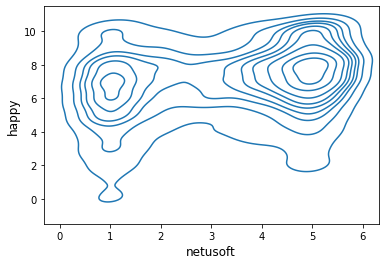

In [124]:
describe_variable(var_label="netusoft",
                  data_df=df,
                  summary_df=df_summary,
                  show_conditional_means=True,
                  show_corr=True)

Following the analysis, the following are the 30 columns identified as interesting for the sake of the study:

In [125]:
int_cols = [key for key, item in vars_comment.items() if item > 3]
print(",\n".join(int_cols))

netusoft,
ppltrst,
pplfair,
psppsgva,
trstlgl,
trstplc,
trstplt,
stflife,
stfeco,
stfgov,
stfdem,
stfedu,
stfhlth,
hmsfmlsh,
imwbcnt,
happy,
sclmeet,
inprdsc,
sclact,
health,
hlthhmp,
atchctr,
atcherp,
dscrgrp,
plnftr,
hhmmb,
gndr,
agea,
dvrcdeva,
maritalb,
chldhhe,
eduyrs,
pdwrk,
edctn,
uempla,
rtrd,
domicil


The others will instead be dropped:

In [126]:
drop_cols = [key for key, item in vars_comment.items() if item <= 3]
print(",\n".join(drop_cols))

pplhlp,
polintr,
actrolga,
psppipla,
cptppola,
trstprl,
trstep,
wrkorg,
badge,
clsprty,
freehms,
hmsacld,
euftf,
imsmetn,
imbgeco,
imueclt,
aesfdrk,
lnghom1,
lnghom2,
vteurmmb,
lvpntyr,
evlvptn,
tygledu,
tyglvp,
anvcld,
acldnmr,
aftjbyc,
advcyc,
yrbrn,
yrbrn2


In [127]:
df.drop(columns=drop_cols, inplace=True)
df_summary = get_summary_table(df, target_col="happy", descr_df=df_descr)
df_summary

,IS_NUMERIC,N_UNIQUE,NA_ABS,NA_REL,MIN,MAX,MEAN,MEDIAN,CORR_TARGET,SHARE_MOST_FREQ,LABEL,TYPE
agea,1,75,21,0.01,16.0,90.0,51.28,52.0,-0.21,0.02,"Age of respondent, calculated",continuous
atchctr,1,11,15,0.01,0.0,10.0,8.06,8.0,0.22,0.29,How emotionally attached to [country],discrete
atcherp,1,11,55,0.02,0.0,10.0,5.66,6.0,0.27,0.19,How emotionally attached to Europe,discrete
chldhhe,1,2,984,0.36,1.0,2.0,1.67,2.0,0.12,0.67,Ever had children living in household,discrete
domicil,1,5,9,0.00,1.0,5.0,3.20,3.0,0.04,0.43,"Domicile, respondent's description",discrete
dscrgrp,1,2,56,0.02,1.0,2.0,1.96,2.0,0.06,0.96,Member of a group discriminated against in thi...,discrete
dvrcdeva,1,2,28,0.01,1.0,2.0,1.92,2.0,0.06,0.92,Ever been divorced/had civil union dissolved,discrete
edctn,1,2,0,0.00,0.0,1.0,0.10,0.0,0.13,0.90,Doing last 7 days: education,discrete
eduyrs,1,30,85,0.03,0.0,37.0,11.50,12.0,0.19,0.23,Years of full-time education completed,continuous
gndr,1,2,0,0.00,1.0,2.0,1.53,2.0,-0.01,0.53,Gender,discrete


## 2 - Variables recoding
In this final part of the initial cleaning we will recode the variable names and values to ensure better usability. 

In [128]:
df_raw = df.copy()

In [129]:
new_names = {
'agea' : "AGE",
'atchctr' : "SCORE_ATTACHED_COUNTRY",
'atcherp' : "SCORE_ATTACHED_EUROPE",
'chldhhe' : "HAD_CHILDREN",
'dvrcdeva' : "HAD_DIVORCED",
'edctn' : "IS_STUDYING",
'eduyrs' : "EDUCATION_YEARS",
'gndr' : "IS_FEMALE",
'happy' : "SCORE_HAPPY",
'health' : "SCORE_HEALTHY",
'hhmmb' : "PEOPLE_IN_HOUSEHOLD",
'hlthhmp' : "SCORE_DISABLE",
'inprdsc' : "PEOPLE_TO_DISCUSS",
'maritalb' : "MARITAL_STATUS",
'pdwrk' : "IS_WORKING",
'pplfair' : "SCORE_PEOPLE_FAIR",
'ppltrst' : "SCORE_PEOPLE_TRUST",
'rtrd' : "IS_RETIRED",
'sclact' : "SOCIAL_ACTIVITIES",
'sclmeet' : "MEET_FRIENDS",
'stfdem' : "SATISFACTION_DEMOCRACY",
'stfeco' : "SATISFACTION_ECONOMY",
'stfedu' : "SATISFACTION_EDUCATION",
'stfgov' : "SATISFACTION_GOVERNMENT",
'stfhlth' : "SATISFACTION_HEALTH",
'stflife' : "SATISFACTION_LIFE",
'trstep' : "TRUST_EUROPARLAMENT",
'trstlgl' : "TRUST_LEGAL_SYSTEM",
'trstplc' : "TRUST_POLICE",
'uempla' : "IS_UNEMPLOYED",
'domicil' : "DOMICILE",
'hmsfmlsh' : "ASHAMED_LGBTQ",
'dscrgrp' : "IS_DISCRIMINATED_GROUP", 
'imwbcnt' : "IMMIGRANTS_COUNTRY_BETTER",
'netusoft' : "INTERNET_USE",
'plnftr' : "FUTURE_PLANNING",
'psppsgva' : "SAYING_IN_POLITICS",
'trstplt' : "TRUST_POLITICIANS",
}

In [130]:
df.rename(columns=new_names, inplace=True)

df_summary = get_summary_table(df, target_col="SCORE_HAPPY")
df_summary

,IS_NUMERIC,N_UNIQUE,NA_ABS,NA_REL,MIN,MAX,MEAN,MEDIAN,CORR_TARGET,SHARE_MOST_FREQ
AGE,1,75,21,0.01,16.0,90.0,51.28,52.0,-0.21,0.02
ASHAMED_LGBTQ,1,5,139,0.05,1.0,5.0,3.86,4.0,0.17,0.36
DOMICILE,1,5,9,0.00,1.0,5.0,3.20,3.0,0.04,0.43
EDUCATION_YEARS,1,30,85,0.03,0.0,37.0,11.50,12.0,0.19,0.23
FUTURE_PLANNING,1,11,0,0.00,0.0,10.0,4.88,5.0,-0.16,0.14
HAD_CHILDREN,1,2,984,0.36,1.0,2.0,1.67,2.0,0.12,0.67
HAD_DIVORCED,1,2,28,0.01,1.0,2.0,1.92,2.0,0.06,0.92
IMMIGRANTS_COUNTRY_BETTER,1,11,78,0.03,0.0,10.0,4.11,4.0,0.19,0.21
INTERNET_USE,1,5,5,0.00,1.0,5.0,3.63,5.0,0.26,0.51
IS_DISCRIMINATED_GROUP,1,2,56,0.02,1.0,2.0,1.96,2.0,0.06,0.96


In [131]:
df.HAD_CHILDREN = df.HAD_CHILDREN.replace(2, 0)
df.HAD_DIVORCED = df.HAD_DIVORCED.replace(2, 0)
df.IS_FEMALE = df.IS_FEMALE - 1
df.IS_DISCRIMINATED_GROUP = df.IS_DISCRIMINATED_GROUP - 1

In [132]:
df_summary = get_summary_table(df, target_col="SCORE_HAPPY")
df_summary

,IS_NUMERIC,N_UNIQUE,NA_ABS,NA_REL,MIN,MAX,MEAN,MEDIAN,CORR_TARGET,SHARE_MOST_FREQ
AGE,1,75,21,0.01,16.0,90.0,51.28,52.0,-0.21,0.02
ASHAMED_LGBTQ,1,5,139,0.05,1.0,5.0,3.86,4.0,0.17,0.36
DOMICILE,1,5,9,0.00,1.0,5.0,3.20,3.0,0.04,0.43
EDUCATION_YEARS,1,30,85,0.03,0.0,37.0,11.50,12.0,0.19,0.23
FUTURE_PLANNING,1,11,0,0.00,0.0,10.0,4.88,5.0,-0.16,0.14
HAD_CHILDREN,1,2,984,0.36,0.0,1.0,0.33,0.0,-0.12,0.67
HAD_DIVORCED,1,2,28,0.01,0.0,1.0,0.08,0.0,-0.06,0.92
IMMIGRANTS_COUNTRY_BETTER,1,11,78,0.03,0.0,10.0,4.11,4.0,0.19,0.21
INTERNET_USE,1,5,5,0.00,1.0,5.0,3.63,5.0,0.26,0.51
IS_DISCRIMINATED_GROUP,1,2,56,0.02,0.0,1.0,0.96,1.0,0.06,0.96


## 3 - Export to Excel

In [133]:
xlwriter = pd.ExcelWriter('output/Cleaned_data.xlsx')

with xlwriter as writer:
    df.to_excel(writer, sheet_name="Edited", index=False)
    df_raw.to_excel(writer, sheet_name="Raw", index=False)
    df_summary.to_excel(writer, sheet_name="Summary", index=True)
    